In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

/home/frabatx/.local/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv('data/complete.csv')
# Controllo come vengono indicizzate le variabili
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      28681 non-null  object 
 1   day            28681 non-null  int64  
 2   month          28681 non-null  int64  
 3   year           28681 non-null  int64  
 4   list_keywords  28681 non-null  object 
 5   keywords       28681 non-null  object 
 6   title          28665 non-null  object 
 7   subtitle       27094 non-null  object 
 8   text           28681 non-null  object 
 9   address        22536 non-null  object 
 10  location       21186 non-null  object 
 11  geometry       28681 non-null  object 
 12  latitude       28468 non-null  float64
 13  longitude      28468 non-null  float64
 14  cod_quart      11326 non-null  float64
 15  nome_quart     11326 non-null  object 
 16  pro_com        19216 non-null  float64
 17  comune         19216 non-null  object 
dtypes: flo

# Analisi argomentativa
Quali sono le keywords piú frequenti?
1) Keywords totali piú frequenti

2) Frequenza annuale di quelle frequenti

3) Prendere in esempio le keywords di riferimento sulla mappa dei fatti di trento, guardare se hanno pattern

In [3]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
    "trasporto" : "trasporti",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [4]:
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

totalKey = uniqueKeyword(df["keywords"])



In [5]:
pd.DataFrame(totalKey[1:20], columns=['key', 'count']).to_csv("../newSite/src/best50key.csv", index=False)

In [6]:
# Somma totale di tutte le keyword uniche 
len(totalKey)

4848

In [7]:
# Studio la variazione delle keywords per ogni anno. Quali sono i trend topic annuali?
years = df.year.unique()

for year in years:
    df_year = df[df['year']==year]
    keywords = list(uniqueKeyword(df_year['keywords']))[:21]
    keywds = []
    for key in keywords:
        if(key[0] != ''):
            keywds.append(key)
    print(year)
    print(keywds)

2020
[['coronavirus', 817], ['trasporti', 197], ['morti', 134], ['orsi', 120], ['strade', 118], ['viabilità', 97], ['incidenti', 87], ['contagi', 80], ['covid', 70], ['Maurizio Fugatti', 70], ['morti coronavirus', 67], ['scuola', 66], ['animali', 63], ['soccorsi alpino', 63], ['mobilità', 61], ['tamponi', 58], ['elezioni comunali trento 2020', 58], ['trento', 57], ['vigili del fuoco', 53], ['dpcm', 52]]
2019
[['strade', 249], ['trasporti', 199], ['incidenti', 164], ['morti', 143], ['viabilità', 139], ['montagna', 115], ['animali', 102], ['droga', 94], ['meteo', 90], ['notizie curiose', 80], ['neve', 78], ['incendi', 74], ['furti', 70], ['mobilità', 67], ['orsi', 62], ['vigili del fuoco', 61], ['ambiente', 60], ['traffico', 59], ['soccorsi alpino', 59], ['weekend', 53]]
2018
[['incidenti', 173], ['strade', 162], ['viabilità', 125], ['montagna', 118], ['morti', 116], ['elezioni provinciali 2018', 115], ['meteo', 109], ['droga', 104], ['notizie curiose', 90], ['maltempo', 89], ['furti', 8

# Analisi Temporale
Frequenza degli articoli annuali, quanti articoli escono all'anno? qual è la crescita? 

* Quali sono i mesi piú caldi dal punto di vista dell'informazione? Anni?

Lo studio ha dimostrato che per quanto riguarda gli anni non c'è una sostanziale crescita o decrescita dal punto di vista della pubblicazione degli articoli. In genere parliamo di una media di 3000 articoli l'anno che possono variare nell'ordine delle centinaia. I dati del 2020 non sono completi poiché si fermano ad inizio Novembre ma vedendo l'andamento degli anni precedenti si puó stimare una pubblicazione di altri ______ articoli.
L'analisi che segue mostra l'andamento delle pubblicazioni in ordine temporale. La prima immagine descrive l'analisi annuale e la seconda l'andamento mensile nel corso di 8 anni di pubblicazioni.
A spiccare sono proprio alcuni mesi che vedono un picco di crescita nell'ordine delle centinaia di articoli. I mesi in questione sono spesso quelli di ritorno dalle vacanze estive come Settembre ed Ottobre. 
Il 2020 é un anno particolare da questo punto di vista, complice la pandemia. Infatti vediamo come nel periodo di Marzo, Aprile le pubblicazioni siano state piú alte della norma, per non parlare di una fortissima diminuzione ad Agosto, riscontrata ogni anno ma accentuata in questo specifico periodo, ed una ripresa impressionante al ritorno delle vacanze che ha portato ad un divario tra agosto e ottobre di circa 150 articoli in piú.

Analizzando quelli che sono gli argomenti principali dei vari mesi ovviamente il coronavirus é il trend topic di questo 2020. 
Ricordarsi che il grafico deve avere per ogni punto anche il topic principale del mese.


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
# Documentazione groupby per le frequenze delle date
year_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1Y')).size().reset_index(name='counts')
month_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1M')).size().reset_index(name='counts')

In [10]:
year_frequency['timestamp'] = year_frequency['timestamp'].apply(lambda x: x.strftime("%Y"))
year_frequency.to_csv("../newSite/src/countPerYear.csv", index=False)

In [11]:
month_frequency['timestamp'] = month_frequency['timestamp'].apply(lambda x: x.strftime("%Y-%m"))

month_frequency.to_csv("../newSite/src/countPerMonth.csv", index=False)
month_frequency

,timestamp,counts
0,2011-11,149
1,2011-12,208
2,2012-01,191
3,2012-02,228
4,2012-03,297
...,...,...
104,2020-07,263
105,2020-08,233
106,2020-09,345
107,2020-10,381


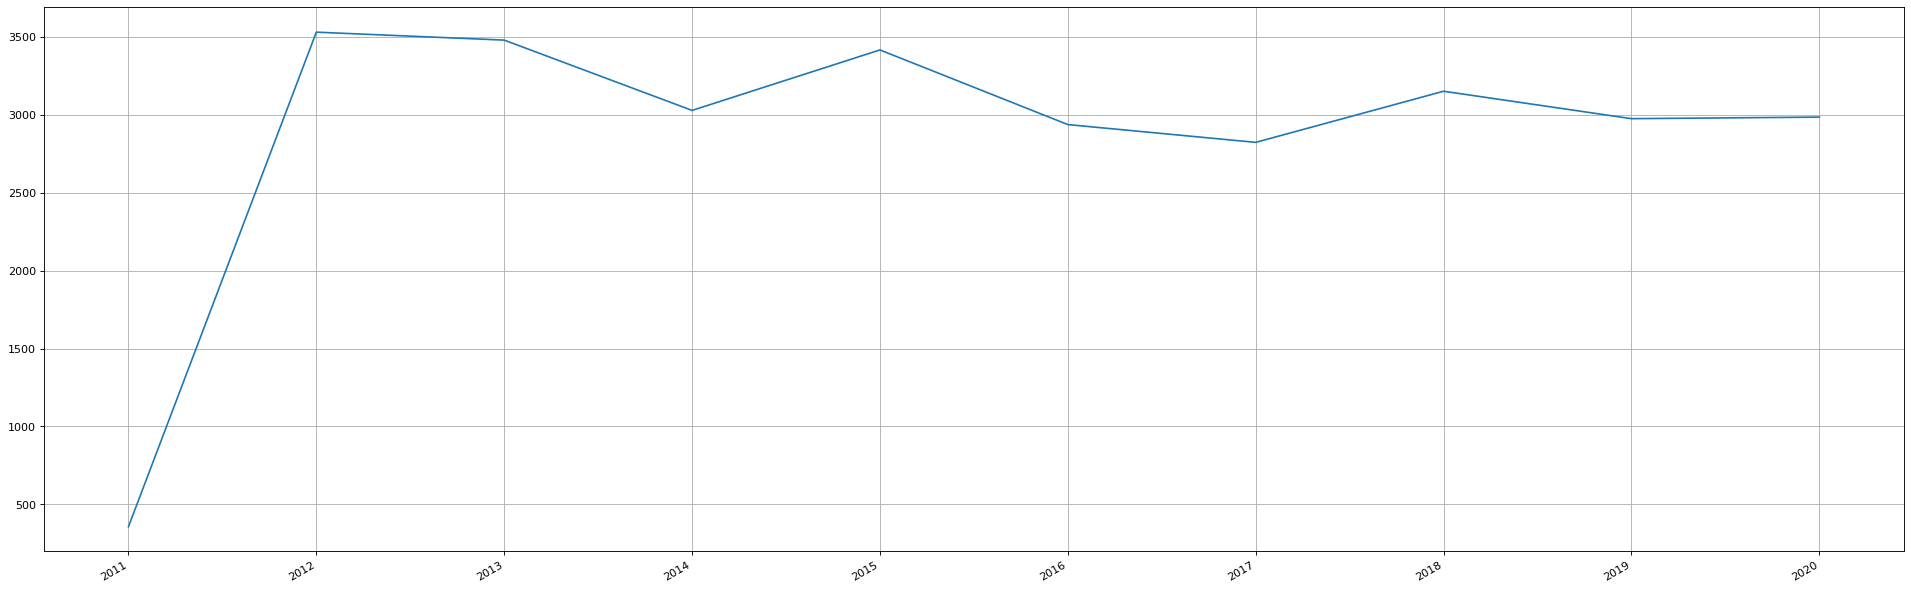

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,10), dpi=80, facecolor='w', edgecolor='k')

y = year_frequency['timestamp'].to_list()
c = year_frequency['counts'].to_list()
plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

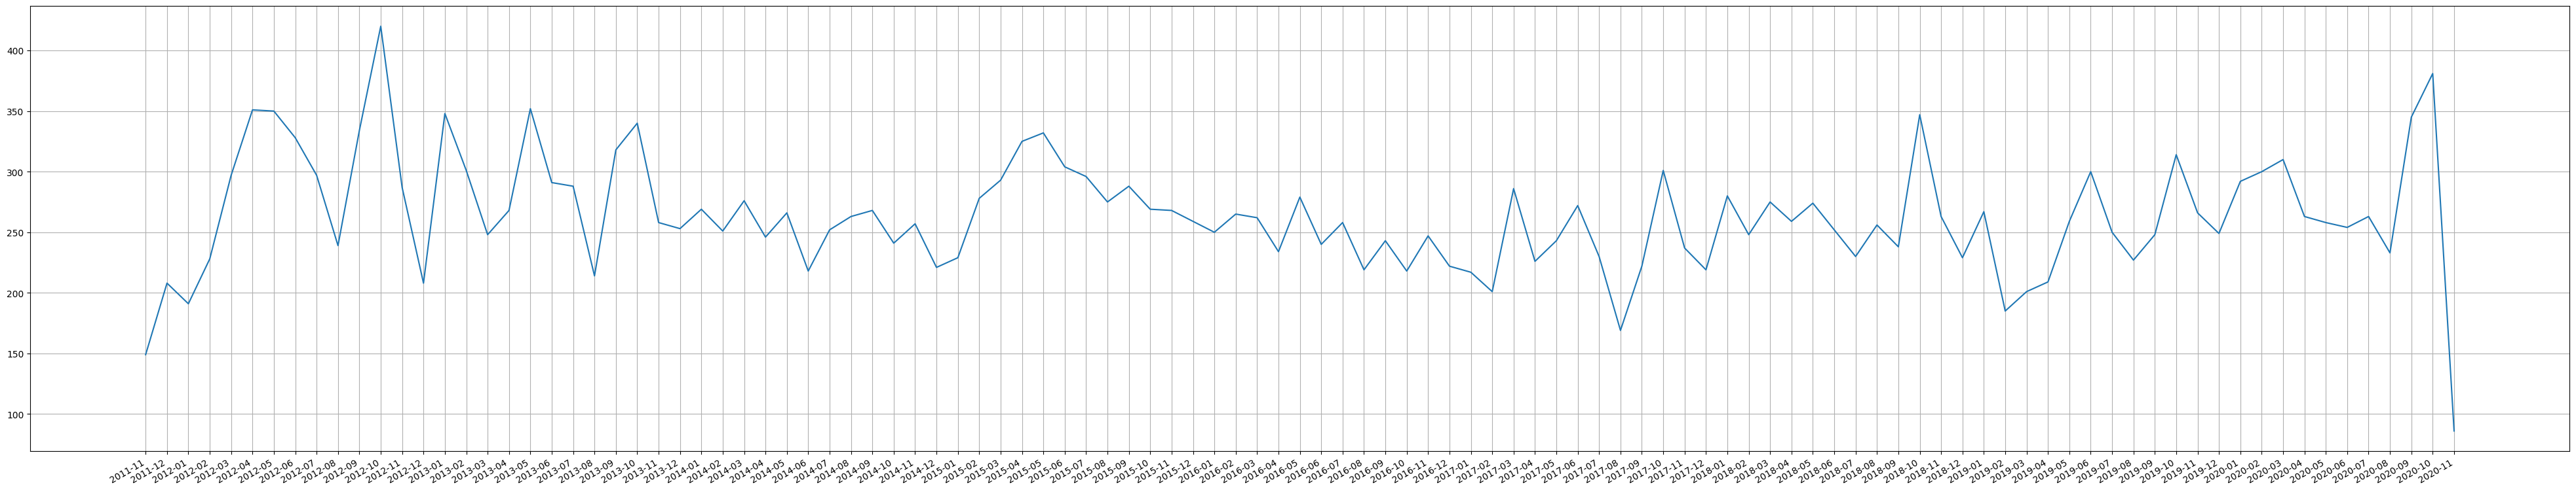

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(50,10), dpi=100, facecolor='w', edgecolor='k')

y = month_frequency['timestamp'].to_list()
c = month_frequency['counts'].to_list()
ax = plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

Lo studio porta a pensare che ci sono mesi che hanno dei picchi particolari, come Settembre ed ottobre. Controllo i top 15 mesi per frequenza e trovo 8 su 15 sono settembre ed ottobre rispetto agli altri mesi. Ma cosa pubblicano?

In [14]:
display(month_frequency.sort_values('counts', ascending=True).head(15))

,timestamp,counts
108,2020-11,86
0,2011-11,149
69,2017-08,169
87,2019-02,185
2,2012-01,191
88,2019-03,201
63,2017-02,201
1,2011-12,208
13,2012-12,208
89,2019-04,209


# Come ha cambiato gli argomenti il coronavirus?

In [15]:
duemila19 = df.loc[(df['timestamp'].dt.year == 2019)]
listaKey2019 = uniqueKeyword(duemila19["keywords"])
duemila20 = df.loc[(df['timestamp'].dt.year == 2020)]
listaKey2020 = uniqueKeyword(duemila20["keywords"])

In [16]:
argomenti2anni = pd.DataFrame(zip(listaKey2019,listaKey2020), columns=[2019,2020])

In [17]:
print(argomenti2anni.head(20).to_string())

                      2019                                 2020
0            [strade, 249]                   [coronavirus, 817]
1         [trasporti, 199]                              [, 209]
2                  [, 195]                     [trasporti, 197]
3         [incidenti, 164]                         [morti, 134]
4             [morti, 143]                          [orsi, 120]
5         [viabilità, 139]                        [strade, 118]
6          [montagna, 115]                      [viabilità, 97]
7           [animali, 102]                      [incidenti, 87]
8              [droga, 94]                        [contagi, 80]
9              [meteo, 90]                          [covid, 70]
10   [notizie curiose, 80]               [Maurizio Fugatti, 70]
11              [neve, 78]              [morti coronavirus, 67]
12           [incendi, 74]                         [scuola, 66]
13             [furti, 70]                        [animali, 63]
14          [mobilità, 67]              

### Secondo approccio
Comparo i best key del 2019 e vedo che cambiamento in fatto di numeri hanno avuto nel 2020

In [18]:
years = [2019, 2020]

df_year = df[df['year']==2019]
keywords2019 = list(uniqueKeyword(df_year['keywords']))[:21]
keys = []
key2019 = []
for key in keywords2019:
    if(key[0] != ''):
        keys.append(key[0])
        key2019.append(key)
key2019 = dict(key2019)
key2019

{'strade': 249,
 'trasporti': 199,
 'incidenti': 164,
 'morti': 143,
 'viabilità': 139,
 'montagna': 115,
 'animali': 102,
 'droga': 94,
 'meteo': 90,
 'notizie curiose': 80,
 'neve': 78,
 'incendi': 74,
 'furti': 70,
 'mobilità': 67,
 'orsi': 62,
 'vigili del fuoco': 61,
 'ambiente': 60,
 'traffico': 59,
 'soccorsi alpino': 59,
 'weekend': 53}

In [19]:
df_year = df[df['year']==2020]
keywords2020 = list(uniqueKeyword(df_year['keywords']))
key2020 =[]
for key in keywords2020:
    if((key[0] != '') and (key[0] in keys) ):
        key2020.append(key)
key2020 = dict(key2020)
key2020

{'trasporti': 197,
 'morti': 134,
 'orsi': 120,
 'strade': 118,
 'viabilità': 97,
 'incidenti': 87,
 'animali': 63,
 'soccorsi alpino': 63,
 'mobilità': 61,
 'vigili del fuoco': 53,
 'droga': 51,
 'meteo': 49,
 'furti': 46,
 'montagna': 45,
 'notizie curiose': 33,
 'incendi': 33,
 'ambiente': 32,
 'traffico': 25,
 'neve': 21,
 'weekend': 11}

In [20]:
cols = ['keys', 'diciannove', 'venti']
ordered2020 = []
for key in keys:
    ordered2020.append(key2020.get(key))
pd.DataFrame(list(zip(keys,key2019.values() ,ordered2020 )), columns=cols).to_csv("../newSite/src/compared20192020.csv", index=False)

# Analisi mensile top Keyword
Abbiamo visto negli ultimi anni Ottobre e le sue argomentazioni, ma quali sono le keywords che hanno caratterizzato ogni mese nel corso degli anni?

Per poterlo realizzare posso utilizzare le funzioni che ho giá creato e ciclarle per creare quello che mi serve

In [21]:
rows = []
for year in range(2012,2021):
    
    # ciclo sui mesi
    for month in range(1,13):
        data = df.loc[(df['timestamp'].dt.month == month)&(df['timestamp'].dt.year == year)]
        lista = uniqueKeyword(data["keywords"])
        #print(year, month, lista[:3])
        rows.append(lista[:20])

In [22]:
arrays = [np.array([2012]*12 +[2013]*12 +[2014]*12 +[2015]*12 +[2016]*12 +[2017]*12 +[2018]*12 +[2019]*12 +[2020]*12), 
          np.array([1,2,3,4,5,6,7,8,9,10,11,12]*9)]

In [23]:
dato = pd.DataFrame(rows, index=arrays, columns=range(1,21))

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(dato)

1   \
2012 1                       [incidenti, 12]   
     2                          [calcio, 15]   
     3                       [incidenti, 21]   
     4                       [incidenti, 19]   
     5                       [incidenti, 30]   
     6                       [incidenti, 19]   
     7                       [incidenti, 19]   
     8                       [incidenti, 29]   
     9                       [incidenti, 27]   
     10                      [incidenti, 23]   
     11                      [incidenti, 14]   
     12                      [incidenti, 11]   
2013 1                       [incidenti, 27]   
     2                       [incidenti, 18]   
     3                           [calcio, 8]   
     4                       [incidenti, 27]   
     5                       [incidenti, 21]   
     6                       [incidenti, 11]   
     7                                [, 15]   
     8                                [, 97]   
     9                               [, 118]   
     10                              [, 137]   
     11                               [, 58]   
     12                               [, 80]   
2014 1                                [, 85]   
     2                                [, 58]   
     3                                [, 75]   
     4                                [, 68]   
     5                                [, 58]   
     6                                [, 63]   
     7                                [, 56]   
     8                                [, 49]   
     9                                [, 46]   
     10                               [, 28]   
     11                               [, 27]   
     12                               [, 16]   
2015 1                             [sci, 15]   
     2                                [, 15]   
     3                                [, 29]   
     4                                [, 50]   
     5   [elezioni comunali 2015 trento, 56]   
     6                                [, 33]   
     7                                [, 27]   
     8                       [viabilità, 20]   
     9                          [scuola, 16]   
     10                               [, 24]   
     11                               [, 25]   
     12                               [, 22]   
2016 1                       [incidenti, 15]   
     2                           [furti, 16]   
     3                          [strade, 20]   
     4                                [, 17]   
     5                          [comuni, 19]   
     6                           [furti, 12]   
     7                                [, 20]   
     8                                [, 19]   
     9                                [, 27]   
     10                          [morti, 15]   
     11                               [, 19]   
     12                        [incendi, 11]   
2017 1                                [, 20]   
     2                       [incidenti, 14]   
     3                       [incidenti, 27]   
     4                        [montagna, 15]   
     5                                [, 17]   
     6                                [, 18]   
     7                                [, 16]   
     8                          [scuola, 32]   
     9                                [, 21]   
     10                           [casa, 47]   
     11                      [incidenti, 16]   
     12                               [, 15]   
2018 1                                [, 20]   
     2                       [incidenti, 21]   
     3                                [, 17]   
     4                       [incidenti, 17]   
     5                  [adunata alpini, 38]   
     6                       [incidenti, 23]   
     7                       [incidenti, 21]   
     8                          [scuola, 21]   
     9       [elezioni provinciali 2018, 18]   
     10      [elezioni provinciali 2018, 62]   
     11                       [maltempo, 48]   
     12   

# Analisi Geografica
L'analisi geografica qui rappresentata prende come riferimento il dataset geolocalizzato e lo studia per quelle che possno essere le componenti geografiche e le componenti argomentative.

Qui rispondiamo a domande come:
* Quali sono i topic piú trattati per le notizie geolocalizzate? In questo modo possiamo vedere che tipo di notizie andiamo a trattare. Mi aspetto che siano notizie prevalentemente di incidenti, strade, notizie di quartiere.
* Tra queste notizie quali sono le piú comuni su trento?
* Quali sono i quartieri di trento con piú notizie?
* C'è una sostanziale differenza tra il centro e la periferia?
* Trento VS Comuni. Quali sono le notizie e che tipo di notizie sono quelle nei comuni?
* Occhio mirato sulla criminalità

In [25]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('data/complete.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      28681 non-null  datetime64[ns]
 1   day            28681 non-null  int64         
 2   month          28681 non-null  int64         
 3   year           28681 non-null  int64         
 4   list_keywords  28681 non-null  object        
 5   keywords       28681 non-null  object        
 6   title          28665 non-null  object        
 7   subtitle       27094 non-null  object        
 8   text           28681 non-null  object        
 9   address        22536 non-null  object        
 10  location       21186 non-null  object        
 11  geometry       28681 non-null  object        
 12  latitude       28468 non-null  float64       
 13  longitude      28468 non-null  float64       
 14  cod_quart      11326 non-null  float64       
 15  nome_quart     1132

In [27]:
len(df[(df['comune'].notnull())])

19216

I punti trovati in trentino sono 19.216.

Quali sono i topic piú trattati per le notizie geolocalizzate? In questo modo possiamo vedere che tipo di notizie andiamo a trattare. Mi aspetto che siano notizie prevalentemente di incidenti, strade, notizie di quartiere.

In [28]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [29]:
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

trento = df[df['comune'] == 'Trento' ]
trentino = df[(df['comune'].notnull())]
nonTrento = df[(df['comune'].notnull())&(df['comune']!="Trento")]
totalKey = uniqueKeyword(df["keywords"])
nonTrentoKey = uniqueKeyword(nonTrento["keywords"])
trentoKey = uniqueKeyword(trento["keywords"])


In [30]:
print("Numero di punti in trentino: ",len(trentino))
print("Numero di punti nei comuni: ",len(nonTrento))
print("Keywors più utilizzate nei comuni: \n", nonTrentoKey[:50])

Numero di punti in trentino:  19216
Numero di punti nei comuni:  7873
Keywors più utilizzate nei comuni: 
 [['incidenti', 763], ['furti', 427], ['', 422], ['carabinieri', 376], ['morti', 366], ['strade', 335], ['incendi', 308], ['viabilità', 250], ['ambiente', 248], ['vigili del fuoco', 232], ['droga', 214], ['incidenti montagna', 212], ['notizie curiose', 210], ['montagna', 201], ['animali', 196], ['soccorsi alpino', 152], ['Elisoccorsi', 152], ['trasporti', 141], ['orsi', 137], ['sci', 134], ['lavoro', 134], ['rovereto', 126], ['natura', 117], ['turismo', 114], ['truffe', 110], ['traffico', 108], ['agricoltura', 103], ['incidenti stradali', 99], ['arresti', 96], ['incidenti motociclistici', 93], ['patente', 86], ['lago di garda', 83], ['sanità', 83], ['sport', 81], ['mobilità', 77], ['scuola', 76], ['comuni', 75], ['incidenti sul lavoro', 75], ['calcio', 73], ['incidente', 72], ['coronavirus', 69], ['indagini', 69], ['minori', 69], ['neve', 68], ['musica', 67], ['investimenti', 66], 

In [31]:
print("Numero di punti a Trento: ",len(trento))
print("Keywors più utilizzate a Trento: \n",trentoKey[:50])

Numero di punti a Trento:  11343
Keywors più utilizzate a Trento: 
 [['', 1209], ['coronavirus', 448], ['università', 365], ['scuola', 329], ['lavoro', 328], ['meteo', 318], ['strade', 311], ['viabilità', 302], ['incidenti', 286], ['furti', 263], ['sport', 259], ['comune', 252], ['basket', 239], ['sanità', 234], ['politica', 231], ['droga', 217], ['traffico', 213], ['notizie curiose', 204], ['morti', 202], ['aquila basket', 201], ['trasporti', 198], ['volley', 181], ['orsi', 180], ['montagna', 176], ['neve', 176], ['sindacati', 170], ['ambiente', 169], ['weekend', 160], ['agricoltura', 159], ['salute', 157], ['animali', 156], ['a22', 156], ['turismo', 151], ['provincia', 150], ['studenti', 150], ['carabinieri', 143], ['lavori pubblici', 142], ['tribunale', 130], ['giovani', 129], ['dati', 126], ['immigrazione', 125], ['eventi', 124], ['autostrada del brennero', 122], ['feste', 122], ['maltempo', 119], ['storia', 118], ['musica', 117], ['economia', 116], ['vigili del fuoco', 116], ['sci

In [32]:
print("Percentuale di notizie su trento")
print((11343/19216)*100), 

Percentuale di notizie su trento
59.028934221482096


(None,)

Questo ci fa capire che le notizie sul coronavirus sono date prevalentemente su Trento, considerando che piú della metá sono geolocalizzate in cittá e solo 69 sono rivolte ai comuni.

Come era prevedibile le notizie principali per i comuni sono gli incidenti, quello che stupisce é che le notizie sui furti siano maggiori nei comuni che in cittá. In realtá non so bene come descrivere quello che ho trovato in questo contesto. Magari é utile contestualizzare il tutto con una mappa che definisce i comuni piú pericolosi magari. Faccio il dataset e vedo.

In [33]:
countArticleComune = nonTrento.groupby(['comune']).size().reset_index(name='counts').sort_values('counts', ascending=False)

Controllo se i comuni che hanno piú articoli sono i piú grandi del Trentino. La risposta é no. Le cittá con piú articoli sono quelle con popolazione maggiore in ordine di densitá di popolazione!!
https://www.tuttitalia.it/trentino-alto-adige/provincia-autonoma-di-trento/88-comuni/popolazione/

In [54]:
import fiona
import geopandas as gpd
fiona.listlayers('data/istat_administrative_units_2020.gpkg')
municipalities = gpd.read_file("data/istat_administrative_units_2020.gpkg",
                               layer="municipalities", 
                               GEOM_POSSIBLE_NAMES="geometry",
                               KEEP_GEOM_COLUMNS="NO")
# filter the province
municipalities_province_trento = municipalities[municipalities.COD_PROV==22]
municipalities_province_trento

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
1257,2,4,22,0,22,22089,022089,Fornace,None,0,"MULTIPOLYGON (((671463.667 5110043.556, 671587..."
1258,2,4,22,0,22,22090,022090,Frassilongo,None,0,"MULTIPOLYGON (((678383.486 5107385.322, 678825..."
1259,2,4,22,0,22,22091,022091,Garniga Terme,None,0,"MULTIPOLYGON (((659718.268 5098543.951, 660423..."
1260,2,4,22,0,22,22092,022092,Giovo,None,0,"MULTIPOLYGON (((668394.632 5121453.303, 669791..."
1261,2,4,22,0,22,22093,022093,Giustino,None,0,"MULTIPOLYGON (((633744.171 5119205.194, 634707..."
...,...,...,...,...,...,...,...,...,...,...,...
4512,2,4,22,0,22,22195,022195,Terzolas,None,0,"MULTIPOLYGON (((648742.270 5136116.640, 648868..."
4513,2,4,22,0,22,22196,022196,Tesero,None,0,"MULTIPOLYGON (((695875.448 5135593.821, 696754..."
4514,2,4,22,0,22,22199,022199,Tione di Trento,None,0,"MULTIPOLYGON (((626583.332 5102329.460, 626863..."
4515,2,4,22,0,22,22200,022200,Ton,None,0,"MULTIPOLYGON (((663108.429 5128319.888, 663654..."


In [55]:
municipalities_province_trento.to_crs("EPSG:4326", inplace=True)
municipalities_province_trento

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
1257,2,4,22,0,22,22089,022089,Fornace,None,0,"MULTIPOLYGON (((207905.193 5114600.895, 208031..."
1258,2,4,22,0,22,22090,022090,Frassilongo,None,0,"MULTIPOLYGON (((214609.116 5111426.174, 215038..."
1259,2,4,22,0,22,22091,022091,Garniga Terme,None,0,"MULTIPOLYGON (((195316.726 5104011.494, 196023..."
1260,2,4,22,0,22,22092,022092,Giovo,None,0,"MULTIPOLYGON (((205705.023 5126217.978, 207077..."
1261,2,4,22,0,22,22093,022093,Giustino,None,0,"MULTIPOLYGON (((170952.030 5126595.559, 171889..."
...,...,...,...,...,...,...,...,...,...,...,...
4512,2,4,22,0,22,22195,022195,Terzolas,None,0,"MULTIPOLYGON (((187203.391 5142339.680, 187323..."
4513,2,4,22,0,22,22196,022196,Tesero,None,0,"MULTIPOLYGON (((234192.745 5138245.552, 235117..."
4514,2,4,22,0,22,22199,022199,Tione di Trento,None,0,"MULTIPOLYGON (((162528.017 5110289.657, 162795..."
4515,2,4,22,0,22,22200,022200,Ton,None,0,"MULTIPOLYGON (((200949.701 5133470.059, 201488..."


municipalities_province_trento['areas'] = municipalities_province_trento['geometry'].area/10**6

municipalities_province_trento = municipalities_province_trento[['COMUNE', 'areas']].sort_values('areas', ascending=False)
municipalities_province_trento = municipalities_province_trento.rename(columns={'COMUNE': 'comune'})

print(pd.merge(countArticleComune, municipalities_province_trento, how='outer', on=['comune']).to_string())

Controllo quali sono i comuni che hanno piú criminalitá in base alle key che ho trovato:
* Furti
* Incidenti

parolaChiave = nonTrento[nonTrento['keywords'].apply(lambda x: 'incidenti' in x)]

print(parolaChiave.groupby(['year', 'comune']).size().to_string())

L'analisi dei furti nei comuni,divisi per anni fanno capire che sono notizie sparse, non di particolare rilevanza, certo il numero dei comuni li fa spiccare rispetto a Trento, in realtá dipende dal numero.
Rovereto é quella che tra tutti è la piú rilevante, nulla di particolarmente rilevante rispetto a trento, un massimo di 10 notizie annuali.
Queste analisi stanno portando alla conclusione che la principale fonte di notizie sia Trento e non il Trentino.

from shapely import wkt
import shapely.geometry
import geopandas as gpd
#df_quartieri = pd.read_csv('data/poli_sociali.csv', delimiter=';')
#df_quartieri = geopandas.read_file('data/poli_sociali.csv')
# loading polygons geodataframe
gdf_polygons = gpd.read_file('data/poli_sociali/poli_sociali.shp')
gdf_polygons.to_crs("EPSG:4326", inplace=True)
#gdf_polygons

counts_df = gdf_polygons.merge(conteggioQuartieriDf, how='inner',left_on=['cod_quart', 'nome_quart'],right_on=['cod_quart', 'nome_quart'])
counts_df

## Transformo i dati in json

In [41]:
countArticleTrentino = trentino.groupby(['comune']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [53]:
municipalities_province_trento['geometry'] = municipalities_province_trento['geometry'].apply(lambda x : shapely.geometry.MultiPolygon(x)) 
municipalities_province_trento

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
1257,2,4,22,0,22,22089,022089,Fornace,None,0,"MULTIPOLYGON (((207905.193 5114600.895, 208031..."
1258,2,4,22,0,22,22090,022090,Frassilongo,None,0,"MULTIPOLYGON (((214609.116 5111426.174, 215038..."
1259,2,4,22,0,22,22091,022091,Garniga Terme,None,0,"MULTIPOLYGON (((195316.726 5104011.494, 196023..."
1260,2,4,22,0,22,22092,022092,Giovo,None,0,"MULTIPOLYGON (((205705.023 5126217.978, 207077..."
1261,2,4,22,0,22,22093,022093,Giustino,None,0,"MULTIPOLYGON (((170952.030 5126595.559, 171889..."
...,...,...,...,...,...,...,...,...,...,...,...
4512,2,4,22,0,22,22195,022195,Terzolas,None,0,"MULTIPOLYGON (((187203.391 5142339.680, 187323..."
4513,2,4,22,0,22,22196,022196,Tesero,None,0,"MULTIPOLYGON (((234192.745 5138245.552, 235117..."
4514,2,4,22,0,22,22199,022199,Tione di Trento,None,0,"MULTIPOLYGON (((162528.017 5110289.657, 162795..."
4515,2,4,22,0,22,22200,022200,Ton,None,0,"MULTIPOLYGON (((200949.701 5133470.059, 201488..."


In [43]:
df_counts_comuni = municipalities_province_trento.merge(countArticleTrentino, how='inner',left_on=['COMUNE'],right_on=['comune'])

In [44]:
df_counts_comuni = df_counts_comuni[['comune', 'counts', 'geometry']]

In [45]:
import shapely.geometry
import geopandas as gpd
df_counts_comuni['geometry'] = df_counts_comuni['geometry'].apply(lambda x : shapely.geometry.MultiPolygon(x)) 

In [49]:
df_counts_comuni.to_file("/home/frabatx/Documents/University/Data_journalism/Project_Article/today_parser/newSite/src/countComuni.geojson", driver='GeoJSON')

<AxesSubplot:>

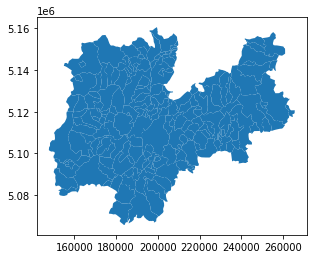

# Analisi Trento

* Qual è il quartiere con piú notizie? Che tipo di notizie ci sono?

Un problema che ho notato é che il dataset Trento pinga le notizie in centro storico anche quando é solo "Trento" come geolocalizzazione. 
Vedo di togliere quelle che hanno address solo Trento. Facendolo perdo 1000 punti ma quello che ne ricavo é la geolocalizzazione di solo punti che hanno address centro storico.
Ora posso fare l'analisi.

In [ ]:
trento

In [ ]:
# Tolgo gli address che contengono solo Trento perché vengono pingati in =centro storico
trento = trento[trento['address']!="Trento"]
trentoKey

In [ ]:
conteggioQuartieriDf = trento.groupby(['nome_quart', 'cod_quart']).size().reset_index(name='counts').sort_values('counts', ascending=False)
conteggioQuartieriDf['cod_quart'] = conteggioQuartieriDf['cod_quart'].apply(lambda x : int(x))

In [ ]:
conteggioQuartieriDf

In [ ]:
from shapely import wkt
import shapely.geometry
import geopandas as gpd
#df_quartieri = pd.read_csv('data/poli_sociali.csv', delimiter=';')
#df_quartieri = geopandas.read_file('data/poli_sociali.csv')
# loading polygons geodataframe
gdf_polygons = gpd.read_file('data/poli_sociali/poli_sociali.shp')
gdf_polygons.to_crs("EPSG:4326", inplace=True)
#gdf_polygons

In [ ]:
counts_df = gdf_polygons.merge(conteggioQuartieriDf, how='inner',left_on=['cod_quart', 'nome_quart'],right_on=['cod_quart', 'nome_quart'])
counts_df

In [ ]:
counts_df = counts_df[['counts', 'cod_quart','nome_quart', 'geometry']]

In [ ]:
counts_df['geometry'] = counts_df['geometry'].apply(lambda x : shapely.geometry.Polygon(x)) 
type(counts_df)

## Transformo i dati in json

#counts_df.to_csv('./data/countsComuni.csv', index=False)
#geojson = counts_df.to_json()
counts_df.to_file("/home/frabatx/Documents/University/Data_journalism/Project_Article/today_parser/newSite/src/countQuartieri.geojson", driver='GeoJSON')
#counts_df.to_geojson()

with open('/home/frabatx/Documents/University/Data_journalism/Project_Article/today_parser/newSite/src/countQuartieri.json', 'w', encoding='utf-8') as f:
    json.dump(geojson, f, ensure_ascii=True)

## Analizzo quali sono le principali notizie per tipo di quartiere

In [ ]:
quartieri = trento['nome_quart'].unique()
quartieri = [i for i in quartieri]
print(type(quartieri))
print(len(np.array(quartieri*9)))

In [ ]:
len(np.array([2012]*len(quartieri) +[2013]*len(quartieri) +[2014]*len(quartieri) +[2015]*len(quartieri) +[2016]*len(quartieri) +[2017]*len(quartieri) +[2018]*len(quartieri) +[2019]*len(quartieri) +[2020]*len(quartieri)))

In [ ]:
rows = []

for quartiere in quartieri:
    data = trento.loc[trento['nome_quart'] == str(quartiere)]
    lista = uniqueKeyword(data["keywords"])
    #print(year, month, lista[:3])
    rows.append(lista[:20])

In [ ]:
arrays = [np.array(quartieri)]

In [ ]:
dato = pd.DataFrame(rows, index=arrays, columns=range(1,21))

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(dato)

In [ ]:
# Dove sono collocate le notizie di furti e droga?
trento[trento['keywords'].apply(lambda x: 'droga' in x)].groupby(['nome_quart']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [ ]:
# Il centro storico é quello piú rappresentativo della cittá 
centro = trento[trento['nome_quart']== "Centro Storico".upper()]

In [ ]:
print(centro[centro['keywords'].apply(lambda x: 'droga' in x)].groupby(pd.Grouper(key='timestamp', freq = '1Y')).size().reset_index(name='counts').to_string())

In [ ]:
print(centro[(centro['keywords'].apply(lambda x: 'droga' in x))&(centro['year'] == 2016)]['title'].to_list())

In [ ]:
trento[trento['keywords'].apply(lambda x: 'furti' in x)].groupby(['nome_quart']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [ ]:
print(trento[trento['keywords'].apply(lambda x: 'droga' in x)].groupby(['nome_quart']).size().to_string())#.sort_values('counts', ascending=False)

In [ ]:
print(centro[centro['keywords'].apply(lambda x: 'furti' in x)].groupby(pd.Grouper(key='timestamp', freq = '1Y')).size().reset_index(name='counts').to_string())

In [ ]:
print(centro[(centro['keywords'].apply(lambda x: 'furti' in x))&(centro['year'] == 2016)]['title'].to_list())

# Analisi Argomentativa
In questa analisi studio le co-occorrenze tra le keywords per capire se in qualche modo alcuni argomenti possano essere collegati e trovare qualche relazione in particolare. 

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_csv('data/complete.csv')
# Controllo come vengono indicizzate le variabili
df.info()

In [ ]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [ ]:
#Check unique keywords
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

total_keywords = uniqueKeyword(df["keywords"])
list(total_keywords[:200])

In [ ]:
common200 = total_keywords[:20]
mostCommonKey = [row[0] for row in common200[1:]] # seleziono le prime

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(50,30), dpi=100, facecolor='w', edgecolor='k')

# Creo una lista boleana 
def filter_df(initial_column, key):
    return key in initial_column

def correlationDataFrame(keywords, df, stringKeywordsColumnName):
    matrix = []
    for index, key in enumerate(keywords):
        row = [0] * len(keywords)
        boolean = df[stringKeywordsColumnName].apply(lambda x: filter_df(x, key))
        filtered_df = df[boolean]
        super_lista = []
        for lista in filtered_df[stringKeywordsColumnName]:
            super_lista.extend(lista)
        for indice, chiave in enumerate(keywords):
            #print('index = {}, conto = {}, chiave = {}'.format(indice, super_lista.count(chiave), chiave))
            row[indice] = super_lista.count(chiave)
        #normalizzo la righa, quindi il grafico non potrá essere letto per colonne
        valoremassimo = max(row)
        normalizzata = [x / valoremassimo for x in row]
        matrix.append(normalizzata)
        
    corrdf = pd.DataFrame(np.triu(matrix), columns=keywords, index=keywords)
    
    return  corrdf

corrdf = correlationDataFrame(mostCommonKey, df, 'keywords')
corrdf.to_csv('correlation.csv')


plt.pcolor(corrdf)
plt.yticks(np.arange(0.5, len(corrdf.index), 1), corrdf.index)
plt.xticks(np.arange(0.5, len(corrdf.columns), 1), corrdf.columns)
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
corrdf

In [ ]:
lista = []
for index, row in corrdf.iterrows():
    print(row.apply(lambda x: x if x>0.3 else None).to_string())
        

In [ ]:
print(lista)

l'analisi argomentativa ha portato a capire che nessuna keyword é particolarmente corelata. Pensiamo che sulle prime 200 é stata trovata solo una correlazione che superasse lo 0.4, che comunque é una correlazione debole.